In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from consolidated_runs import run_simulations

from Pearson.pearson import Pearson

sys.path.append(os.getcwd())

/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
import random

def sample_with_proportion(total, targets, proportion):
    total_sample = 10
    num_special = int(total_sample * proportion)
    special = np.random.choice(targets, num_special, replace=False)

    remaining = list(set(total) - set(targets))
    normal = np.random.choice(remaining, total_sample - num_special, replace=False)

    final = np.concatenate([special, normal])
    np.random.shuffle(final)
    return final

In [4]:
# datasets = range(1, 4) # DS3
# run_simulations(datasets,
#             sergio=True,
#             saucie=True, 
#             scScope=True, 
#             deepImpute=True, 
#             magic=True, 
#             genie=False,
#             arboreto=False,
#             pearson=False,
#             roc=False,
#             precision_recall_k=False
#         )

In [5]:
imp_dir = os.path.join(os.getcwd(), 'imputations')
print(imp_dir)
for i in range(1, 4):
    load_dir = os.path.join(imp_dir, f'DS{i}')
    save_name = 'DS6_expr.npy'

    expr = np.load(os.path.join(load_dir, save_name))
    print(expr.shape)
    file_name = 'expr_shape.csv'
    if not os.path.exists(os.path.join(load_dir, file_name)):
        npfile = np.load(os.path.join(load_dir, save_name))
        shap = npfile.shape
        print(shap)
        df = pd.DataFrame([shap])
        df.to_csv(load_dir + '/' + file_name, index=False)

/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations
(9, 100, 300)
(9, 100, 300)
(9, 400, 300)
(9, 400, 300)
(9, 1200, 300)
(9, 1200, 300)


In [6]:
imp_dir = os.path.join(os.getcwd(), 'imputations')

def run_pearson_ranking(proportion):
    print("Running Pearson ranking tests with proportion", proportion)
    for i in range(1, 4):
        gt_file = None
        if i == 1:
            gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        elif i == 2:
            gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        elif i == 3:
            gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        
        # For now, just load clean data, save as csv, and load it back in
        methods = ['Clean', 'Noisy', 'SAUCIE', 'scScope', 'DeepImpute', 'MAGIC']
        file_name = ''
        save_name = ''
        for method in methods:
            if method == 'Clean':
                file_name = f'DS6_clean.npy'
                save_name = f'DS6_clean.csv'
            elif method == 'Noisy':
                file_name = f'DS6_45.npy'
                save_name = f'DS6_45.csv'
            elif method == 'SAUCIE':
                file_name = f'yhat_SAUCIE.npy'
                save_name = f'yhat_SAUCIE.csv'
            elif method == 'scScope':
                file_name = f'yhat_scScope.npy'
                save_name = f'yhat_scScope.csv'
            elif method == 'DeepImpute':
                file_name = f'yhat_deepImpute.npy'
                save_name = f'yhat_deepImpute.csv'
            elif method == 'MAGIC':
                file_name = f'yhat_MAGIC_t_auto.npy'
                save_name = f'yhat_MAGIC_t_auto.csv'
            load_dir = os.path.join(imp_dir, f'DS{i}')
            if not os.path.exists(os.path.join(imp_dir, f'DS{i}', save_name)):
                npfile = np.load(load_dir + '/' + file_name)
                df = pd.DataFrame(npfile)
                df.to_csv(load_dir + '/' + save_name, index=False)
            clean_df = pd.read_csv(os.path.join(load_dir, save_name))
            
            # Read ground truth
            gt = pd.read_csv(gt_file, header=None)
            confirmed_genes = gt[0].unique()

            # Run Pearson on clean and noisy data
            pearson = Pearson(np.transpose(clean_df), '')
            p_values = pearson.values
            np.fill_diagonal(p_values, 0)
            pearson = pd.DataFrame(p_values, index=pearson.columns, columns=pearson.columns)

            total = 0
            for r in range(50):
                sampled = sample_with_proportion(clean_df.index.tolist(), confirmed_genes, proportion)
            # Take subset of pearson data with only the sampled genes
                p_subset = pearson.loc[sampled]
            #print(p_subset)
            # Rank the expression pairs by the absolute value of the pearson correlation
                melted = pd.melt(p_subset.reset_index(), id_vars=['index'], value_vars=p_subset.columns)
                melted.columns = ['input', 'target', 'correlation']
                melted_sorted = melted.sort_values(by='correlation', ascending=False)
                ranked_list = list(melted_sorted.itertuples(index=False, name=None))[:10]
            # Calculate the proportion of confirmed genes in the top k of the ranked pairs
                top_10 = [(input, target) for input, target, _ in ranked_list]
                true_pairs = set(tuple(x) for x in gt.values)
                matches = sum(1 for pair in top_10 if pair in true_pairs)
                prop = matches / len(top_10)
                total += prop

            print(f"DS{i}", method, total / 50)

In [7]:
# run_pearson_ranking(0.1)
# run_pearson_ranking(0.2)
# run_pearson_ranking(0.3)

In [8]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import random

def run_pearson_edge_sampling(proportion):
    print("Running Pearson edge sampling tests with proportion", proportion)
    imp_dir = os.path.join(os.getcwd(), 'imputations')
    
    for i in range(1, 4):
        if i == 1:
            gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        elif i == 2:
            gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        elif i == 3:
            gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        
        methods = ['Clean', 'Noisy', 'SAUCIE', 'scScope', 'DeepImpute', 'MAGIC']
        
        for method in methods:
            file_name = f'DS{i}_{method}.csv'  # Adjusted for simplicity
            load_dir = os.path.join(imp_dir, f'DS{i}')
            data_file_path = os.path.join(load_dir, file_name)

            if not os.path.exists(data_file_path):
                print(f"File {data_file_path} does not exist. Skipping.")
                continue
            
            clean_df = pd.read_csv(data_file_path)
            gt = pd.read_csv(gt_file, header=None)
            
            confirmed_edges = set(tuple(x) for x in gt.values)
            
            all_possible_edges = [(row, col) for row in clean_df.columns for col in clean_df.columns if row != col]
            num_edges_to_sample = int(len(all_possible_edges) * proportion)
            
            total = 0
            for r in range(50):
                sampled_edges = random.sample(all_possible_edges, num_edges_to_sample)
                matches = 0
                for edge in sampled_edges:
                    gene1, gene2 = edge
                    corr, _ = pearsonr(clean_df[gene1], clean_df[gene2])
                    # Check if this edge is in the confirmed edges and if the correlation is significant
                    if edge in confirmed_edges and abs(corr) > 0.5:  # Threshold for "significant" correlation can be adjusted
                        matches += 1
                prop = matches / len(sampled_edges)
                total += prop
            
            print(f"DS{i} {method}: Proportion of significant confirmed edges = {total / 50}")

# Example usage
proportion = 0.1
run_pearson_edge_sampling(proportion)


Running Pearson edge sampling tests with proportion 0.1
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_Clean.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_Noisy.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_SAUCIE.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_scScope.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_DeepImpute.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS1/DS1_MAGIC.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS2/DS2_Clean.csv does not exist. Skipping.
File /Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/imputations/DS2/

In [11]:
from parallel_utils import process_iteration
from time import time
import concurrent
from concurrent.futures import ProcessPoolExecutor

def edge_finding_experiment(dataset_id, last_iteration=0, fixed_edge=False):
    print("Running edge finding experiment")
    gt_file = None
    if dataset_id == 1:
        gt_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Interaction_cID_4.txt'
        regs_path = './SERGIO/data_sets/De-noised_100G_9T_300cPerT_4_DS1/Regs_cID_4.txt'
    elif dataset_id == 2:
        gt_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Interaction_cID_5.txt'
        regs_path = './SERGIO/data_sets/De-noised_400G_9T_300cPerT_5_DS2/Regs_cID_5.txt'
    elif dataset_id == 3:
        gt_file = 'SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/gt_GRN.csv'
        target_file = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Interaction_cID_6.txt'
        regs_path = './SERGIO/data_sets/De-noised_1200G_9T_300cPerT_6_DS3/Regs_cID_6.txt'
        
    reg_df = pd.read_csv(regs_path, header=None)
    master_regs = [int(m) for m in reg_df[0].values]
    true_pearson = pd.DataFrame()
    gt = pd.read_csv(gt_file, header=None)
    imp_dir = os.path.join(os.getcwd(), 'imputations')
    load_dir = os.path.join(imp_dir, f'DS{dataset_id}')
    ranks = []
    correlations = []

    # check if experiment file exists for this dataset
    experiment_dir = os.path.join(os.getcwd(), 'experiments/edge_finding/')
    if not os.path.exists(experiment_dir):
        os.makedirs(experiment_dir)
    experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_edge_finding_experiment.csv")
    if fixed_edge:
        experiment_file = os.path.join(experiment_dir, f"DS{dataset_id}_edge_finding_experiment_fixed_edge.csv")
    if os.path.exists(experiment_file) and last_iteration != 0:
        df = pd.read_csv(experiment_file)
        ranks = df['Rank'].values.tolist()
        correlations = df['Correlation'].values.tolist()  
    
    fixed_chosen_pair = None
    
    with ProcessPoolExecutor(max_workers=4) as executor:
        futures = []
        for iteration in tqdm(range(last_iteration, 51)):
            file_extension = ''
            if iteration == 0:
                #run_sergio(target_file, regs_path, i, file_extension)
                clean_df = pd.DataFrame(np.load(os.path.join(load_dir, f"DS6_clean{file_extension}.npy")))
                true_pearson = Pearson(np.transpose(clean_df), '')
                p_values = true_pearson.values
                np.fill_diagonal(p_values, 0)
                true_pearson = pd.DataFrame(p_values, index=true_pearson.columns, columns=true_pearson.columns)
            else:
                file_extension = f'_iter{iteration}'
                futures.append(executor.submit(process_iteration, iteration, target_file, regs_path, master_regs, load_dir, imp_dir, dataset_id, file_extension))
        iter = 0
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            pearson, chosen_pair, temp_target, f_ext = future.result()
            if fixed_edge and iter == 0:
                fixed_chosen_pair = chosen_pair
            elif fixed_edge:
                while fixed_chosen_pair is None:
                    time.sleep(0.1)
                chosen_pair = fixed_chosen_pair
            regulator_row = pearson.loc[chosen_pair[0]]
            true_regulator_row = true_pearson.loc[chosen_pair[0]]
            
            # Take difference between calculated and true values
            abs_diff = np.abs(true_regulator_row - regulator_row)
            sorted_row = abs_diff.sort_values(ascending=False)

            #print(abs_diff.index(chosen_pair[1]), sorted_row.index(chosen_pair[1]))
            rank_target = sorted_row.index.get_loc(chosen_pair[1])
            ranks.append(rank_target)
            rank_value = sorted_row.iloc[rank_target]
            correlations.append(rank_value)
            # add to experiment file
            df = pd.DataFrame({'Rank': ranks, 'Correlation': correlations})
            df.to_csv(experiment_file, index=False)
                    
            print(chosen_pair[0], chosen_pair[1], rank_target, rank_value)
            print("Current iteration:", iter, f"Mean rankings for DS{dataset_id} added edge:", np.mean(ranks), np.mean(correlations))
            # delete most temp files, keep every five
            if iter % 10 != 0:
                os.remove(temp_target)
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean{f_ext}.npy"))
                os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_noisy{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_expr{f_ext}.npy"))
            os.remove(os.path.join(imp_dir, f'DS{dataset_id}', f"DS6_clean_counts{f_ext}.npy"))
            iter += 1
        print(f"Mean rankings for DS{dataset_id} added edge:", np.mean(ranks), np.mean(correlations))

In [12]:
edge_finding_experiment(dataset_id=1, last_iteration=0, fixed_edge=False)
edge_finding_experiment(dataset_id=1, last_iteration=0, fixed_edge=True)
edge_finding_experiment(dataset_id=2, last_iteration=0, fixed_edge=False)
edge_finding_experiment(dataset_id=2, last_iteration=0, fixed_edge=True)
edge_finding_experiment(dataset_id=3, last_iteration=0, fixed_edge=False)
edge_finding_experiment(dataset_id=3, last_iteration=0, fixed_edge=True)

Running edge finding experiment


  0%|          | 0/50 [00:00<?, ?it/s]/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders

1.0 85 3 0.15732718053112638
Current iteration: 0 Mean rankings for DS1 added edge: 3.0 0.15732718053112638
1.0 76 5 0.13892885646219436
Current iteration: 1 Mean rankings for DS1 added edge: 4.0 0.14812801849666035
84.0 0 0 0.1823507302773088
Current iteration: 2 Mean rankings for DS1 added edge: 2.6666666666666665 0.15953558909020985
84.0 35 0 0.32549364204760134
Current iteration: 3 Mean rankings for DS1 added edge: 2.0 0.20102510232955773


 10%|█         | 5/50 [01:41<13:13, 17.64s/it]

67.0 28 3 0.1437943670493065
Current iteration: 4 Mean rankings for DS1 added edge: 2.2 0.1895789552735075


 12%|█▏        | 6/50 [01:41<09:41, 13.22s/it]

1.0 87 2 0.15740186719293697
Current iteration: 5 Mean rankings for DS1 added edge: 2.1666666666666665 0.18421610726007906
44.0 79 79 0.010811559276534818
Current iteration: 6 Mean rankings for DS1 added edge: 13.142857142857142 0.15944402897671558


 16%|█▌        | 8/50 [01:41<05:23,  7.70s/it]

17.0 59 56 0.04386072622045015
Current iteration: 7 Mean rankings for DS1 added edge: 18.5 0.14499611613218244


 20%|██        | 10/50 [02:29<08:31, 12.79s/it]

67.0 8 12 0.0945483691580703
Current iteration: 8 Mean rankings for DS1 added edge: 17.77777777777778 0.13939081091283667
74.0 51 6 0.14319491307326496
Current iteration: 9 Mean rankings for DS1 added edge: 16.6 0.1397712211288795


 22%|██▏       | 11/50 [02:29<06:10,  9.49s/it]

44.0 7 0 0.25361998888117443
Current iteration: 10 Mean rankings for DS1 added edge: 15.090909090909092 0.15012110910636087


 24%|██▍       | 12/50 [02:30<04:25,  6.98s/it]

17.0 51 72 0.018332538544718002
Current iteration: 11 Mean rankings for DS1 added edge: 19.833333333333332 0.13913872822622395


 28%|██▊       | 14/50 [03:17<07:51, 13.09s/it]

44.0 27 0 0.2987759012408142
Current iteration: 12 Mean rankings for DS1 added edge: 18.307692307692307 0.1514185107658078
84.0 48 24 0.07001847563878853
Current iteration: 13 Mean rankings for DS1 added edge: 18.714285714285715 0.14560422254244929


 30%|███       | 15/50 [03:17<05:27,  9.36s/it]

67.0 20 0 0.2435788484746125
Current iteration: 14 Mean rankings for DS1 added edge: 17.466666666666665 0.1521358642712602


 32%|███▏      | 16/50 [03:18<03:48,  6.72s/it]

74.0 48 0 0.19282055281850025
Current iteration: 15 Mean rankings for DS1 added edge: 16.375 0.15467865730546265


 34%|███▍      | 17/50 [04:04<10:09, 18.48s/it]

1.0 74 28 0.06854152892016714
Current iteration: 16 Mean rankings for DS1 added edge: 17.058823529411764 0.14961176740044527


 38%|███▊      | 19/50 [04:05<04:47,  9.28s/it]

17.0 32 1 0.15407460856838567
Current iteration: 17 Mean rankings for DS1 added edge: 16.166666666666668 0.1498597030208864
14.0 87 61 0.046784085252629254
Current iteration: 18 Mean rankings for DS1 added edge: 18.526315789473685 0.1444346705067676


 40%|████      | 20/50 [04:05<03:17,  6.59s/it]

93.0 58 14 0.09120718468425587
Current iteration: 19 Mean rankings for DS1 added edge: 18.3 0.141773296215642


 42%|████▏     | 21/50 [04:52<09:02, 18.70s/it]

14.0 87 93 0.008048580218228962
Current iteration: 20 Mean rankings for DS1 added edge: 21.857142857142858 0.13540545259671757


 46%|████▌     | 23/50 [04:53<04:11,  9.33s/it]

56.0 46 21 0.09901346220905606
Current iteration: 21 Mean rankings for DS1 added edge: 21.818181818181817 0.13375127121546024
74.0 15 8 0.11595371766289848
Current iteration: 22 Mean rankings for DS1 added edge: 21.217391304347824 0.1329774645392619


 48%|████▊     | 24/50 [04:53<02:52,  6.63s/it]

67.0 97 3 0.1599049586860307
Current iteration: 23 Mean rankings for DS1 added edge: 20.458333333333332 0.13409944346204394


 50%|█████     | 25/50 [05:40<07:50, 18.80s/it]

74.0 37 10 0.10980800047306319
Current iteration: 24 Mean rankings for DS1 added edge: 20.04 0.1331277857424847
93.0 7 10 0.11078921576218946
Current iteration: 25 Mean rankings for DS1 added edge: 19.653846153846153 0.13226860997401182


 54%|█████▍    | 27/50 [05:41<03:54, 10.18s/it]

17.0 16 23 0.07200534285344651
Current iteration: 26 Mean rankings for DS1 added edge: 19.77777777777778 0.1300366371176946


 56%|█████▌    | 28/50 [05:41<02:50,  7.73s/it]

14.0 78 23 0.09690326725534276
Current iteration: 27 Mean rankings for DS1 added edge: 19.892857142857142 0.12885330247975343


 58%|█████▊    | 29/50 [06:29<06:21, 18.18s/it]

74.0 31 18 0.10528632697129237
Current iteration: 28 Mean rankings for DS1 added edge: 19.82758620689655 0.12804064815187546
1.0 99 22 0.08367301620305512
Current iteration: 29 Mean rankings for DS1 added edge: 19.9 0.1265617270869148
14.0 94 5 0.15518975807928484
Current iteration: 30 Mean rankings for DS1 added edge: 19.419354838709676 0.1274852119576364


 64%|██████▍   | 32/50 [06:29<02:35,  8.64s/it]

56.0 98 76 0.016116249150141426
Current iteration: 31 Mean rankings for DS1 added edge: 21.1875 0.1240049318699022


 66%|██████▌   | 33/50 [07:17<04:40, 16.49s/it]

17.0 27 23 0.07504753861764316
Current iteration: 32 Mean rankings for DS1 added edge: 21.242424242424242 0.12252137449862162


 70%|███████   | 35/50 [07:17<02:26,  9.80s/it]

67.0 36 8 0.11064956695769207
Current iteration: 33 Mean rankings for DS1 added edge: 20.852941176470587 0.12217220368859427
44.0 13 2 0.13849903632858063
Current iteration: 34 Mean rankings for DS1 added edge: 20.314285714285713 0.12263868462116531
62.0 30 4 0.15085176499181843
Current iteration: 35 Mean rankings for DS1 added edge: 19.86111111111111 0.12342238129812791


 74%|███████▍  | 37/50 [08:05<03:22, 15.55s/it]

84.0 57 0 0.1973320037699732
Current iteration: 36 Mean rankings for DS1 added edge: 19.324324324324323 0.12541993866223183


 76%|███████▌  | 38/50 [08:05<02:25, 12.10s/it]

74.0 51 0 0.25782300756055776
Current iteration: 37 Mean rankings for DS1 added edge: 18.81578947368421 0.12890422994902986


 78%|███████▊  | 39/50 [08:05<01:41,  9.20s/it]

84.0 16 0 0.2593647270002183
Current iteration: 38 Mean rankings for DS1 added edge: 18.333333333333332 0.13224937089906033
62.0 38 0 0.23217804913902493
Current iteration: 39 Mean rankings for DS1 added edge: 17.875 0.13474758785505947


 82%|████████▏ | 41/50 [08:53<02:16, 15.20s/it]

14.0 90 6 0.15165406220189598
Current iteration: 40 Mean rankings for DS1 added edge: 17.585365853658537 0.13515994088790914


 84%|████████▍ | 42/50 [08:53<01:34, 11.83s/it]

44.0 26 0 0.32449793270317184
Current iteration: 41 Mean rankings for DS1 added edge: 17.166666666666668 0.13966798831208205


 86%|████████▌ | 43/50 [08:54<01:03,  9.05s/it]

1.0 97 0 0.1908674152704186
Current iteration: 42 Mean rankings for DS1 added edge: 16.767441860465116 0.14085867265995036


 88%|████████▊ | 44/50 [08:54<00:40,  6.77s/it]

44.0 43 0 0.38539705845303124
Current iteration: 43 Mean rankings for DS1 added edge: 16.386363636363637 0.14641636324615673


 90%|█████████ | 45/50 [09:41<01:27, 17.56s/it]

44.0 36 25 0.07678420856304904
Current iteration: 44 Mean rankings for DS1 added edge: 16.57777777777778 0.14486898203097656


 92%|█████████▏| 46/50 [09:41<00:51, 12.75s/it]

74.0 29 0 0.28739265106504674
Current iteration: 45 Mean rankings for DS1 added edge: 16.217391304347824 0.147967322662152


 94%|█████████▍| 47/50 [09:42<00:27,  9.26s/it]

62.0 11 0 0.2458415209049919
Current iteration: 46 Mean rankings for DS1 added edge: 15.872340425531915 0.15004975241199967


 96%|█████████▌| 48/50 [09:42<00:13,  6.69s/it]

67.0 47 67 0.019605565651924672
Current iteration: 47 Mean rankings for DS1 added edge: 16.9375 0.14733216518783143


 98%|█████████▊| 49/50 [10:27<00:17, 17.83s/it]

17.0 65 1 0.17793702963161162
Current iteration: 48 Mean rankings for DS1 added edge: 16.612244897959183 0.14795675425811267


100%|██████████| 50/50 [10:27<00:00, 12.55s/it]

93.0 24 0 0.256699585277279
Current iteration: 49 Mean rankings for DS1 added edge: 16.28 0.150131610878496
Mean rankings for DS1 added edge: 16.28 0.150131610878496


Running edge finding experiment


  0%|          | 0/50 [00:00<?, ?it/s]/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders

17.0 20 71 0.019726525970408693
Current iteration: 0 Mean rankings for DS1 added edge: 71.0 0.019726525970408693


  4%|▍         | 2/50 [00:52<17:27, 21.83s/it]

17.0 20 26 0.06694262326083532
Current iteration: 1 Mean rankings for DS1 added edge: 48.5 0.043334574615622005
17.0 20 70 0.018709748796691378
Current iteration: 2 Mean rankings for DS1 added edge: 55.666666666666664 0.03512629934264513


  8%|▊         | 4/50 [00:53<06:18,  8.22s/it]

17.0 20 78 0.014622094957009113
Current iteration: 3 Mean rankings for DS1 added edge: 61.25 0.030000248246236125


 10%|█         | 5/50 [01:39<15:03, 20.08s/it]

17.0 20 40 0.05233292692710652
Current iteration: 4 Mean rankings for DS1 added edge: 57.0 0.0344667839824102


 14%|█▍        | 7/50 [01:41<07:09,  9.99s/it]

17.0 20 27 0.11850895084600199
Current iteration: 5 Mean rankings for DS1 added edge: 52.0 0.04847381179300884
17.0 20 19 0.086504834101894
Current iteration: 6 Mean rankings for DS1 added edge: 47.285714285714285 0.05390681497999244


 16%|█▌        | 8/50 [01:41<05:00,  7.15s/it]

17.0 20 33 0.07260695332982475
Current iteration: 7 Mean rankings for DS1 added edge: 45.5 0.05624433227372147


 18%|█▊        | 9/50 [02:27<12:52, 18.85s/it]

17.0 20 31 0.06977871122752566
Current iteration: 8 Mean rankings for DS1 added edge: 43.888888888888886 0.05774815215747749


 20%|██        | 10/50 [02:28<08:59, 13.48s/it]

17.0 20 7 0.10701587315617143
Current iteration: 9 Mean rankings for DS1 added edge: 40.2 0.06267492425734689


 22%|██▏       | 11/50 [02:29<06:12,  9.56s/it]

17.0 20 57 0.031171823153101325
Current iteration: 10 Mean rankings for DS1 added edge: 41.72727272727273 0.059811005975142745


 24%|██▍       | 12/50 [02:29<04:21,  6.89s/it]

17.0 20 46 0.046073275212290654
Current iteration: 11 Mean rankings for DS1 added edge: 42.083333333333336 0.0586661950782384


 26%|██▌       | 13/50 [03:15<11:27, 18.59s/it]

17.0 20 56 0.034216565737575255
Current iteration: 12 Mean rankings for DS1 added edge: 43.15384615384615 0.05678545435972585


 28%|██▊       | 14/50 [03:16<08:00, 13.34s/it]

17.0 20 10 0.10934770184170274
Current iteration: 13 Mean rankings for DS1 added edge: 40.785714285714285 0.06053990060843849


 30%|███       | 15/50 [03:17<05:30,  9.46s/it]

17.0 20 43 0.056084078692408695
Current iteration: 14 Mean rankings for DS1 added edge: 40.93333333333333 0.0602428458140365


 32%|███▏      | 16/50 [03:18<03:54,  6.89s/it]

17.0 20 7 0.11847529439832186
Current iteration: 15 Mean rankings for DS1 added edge: 38.8125 0.06388237385055433


 34%|███▍      | 17/50 [04:03<10:07, 18.42s/it]

17.0 20 53 0.03334175545468129
Current iteration: 16 Mean rankings for DS1 added edge: 39.64705882352941 0.06208586688609121


 36%|███▌      | 18/50 [04:04<07:02, 13.21s/it]

17.0 20 37 0.06538378653242026
Current iteration: 17 Mean rankings for DS1 added edge: 39.5 0.0622690846442206


 38%|███▊      | 19/50 [04:04<04:51,  9.41s/it]

17.0 20 52 0.03575169130862019
Current iteration: 18 Mean rankings for DS1 added edge: 40.1578947368421 0.06087343236339953


 40%|████      | 20/50 [04:06<03:27,  6.93s/it]

17.0 20 52 0.04571464518343685
Current iteration: 19 Mean rankings for DS1 added edge: 40.75 0.0601154930044014


 42%|████▏     | 21/50 [04:51<08:58, 18.57s/it]

17.0 20 83 0.01760815898947482
Current iteration: 20 Mean rankings for DS1 added edge: 42.76190476190476 0.05809133424178584


 44%|████▍     | 22/50 [04:52<06:13, 13.35s/it]

17.0 20 52 0.03556085998446723
Current iteration: 21 Mean rankings for DS1 added edge: 43.18181818181818 0.05706722177554409


 46%|████▌     | 23/50 [04:53<04:16,  9.49s/it]

17.0 20 1 0.14428181105213703
Current iteration: 22 Mean rankings for DS1 added edge: 41.34782608695652 0.060859160439743785


 48%|████▊     | 24/50 [04:54<03:03,  7.07s/it]

17.0 20 30 0.06755933229578681
Current iteration: 23 Mean rankings for DS1 added edge: 40.875 0.06113833426707891


 50%|█████     | 25/50 [05:39<07:41, 18.47s/it]

17.0 20 84 0.008348939002034012
Current iteration: 24 Mean rankings for DS1 added edge: 42.6 0.05902675845647711


 52%|█████▏    | 26/50 [05:41<05:20, 13.36s/it]

17.0 20 81 0.010379599173058807
Current iteration: 25 Mean rankings for DS1 added edge: 44.07692307692308 0.057155713868653334


 54%|█████▍    | 27/50 [05:42<03:39,  9.54s/it]

17.0 20 75 0.018204920631991556
Current iteration: 26 Mean rankings for DS1 added edge: 45.22222222222222 0.055713091896925124


 56%|█████▌    | 28/50 [05:43<02:36,  7.09s/it]

17.0 20 81 0.014293925094260307
Current iteration: 27 Mean rankings for DS1 added edge: 46.5 0.0542338359396871


 58%|█████▊    | 29/50 [06:26<06:13, 17.79s/it]

17.0 20 89 0.004330130463102211
Current iteration: 28 Mean rankings for DS1 added edge: 47.96551724137931 0.05251301850946004


 60%|██████    | 30/50 [06:29<04:27, 13.37s/it]

17.0 20 7 0.13326834691020592
Current iteration: 29 Mean rankings for DS1 added edge: 46.6 0.055204862789484895


 62%|██████▏   | 31/50 [06:29<03:00,  9.49s/it]

17.0 20 4 0.17009457285485707
Current iteration: 30 Mean rankings for DS1 added edge: 45.225806451612904 0.05891098246901303


 64%|██████▍   | 32/50 [06:31<02:08,  7.15s/it]

17.0 20 8 0.1350790652337366
Current iteration: 31 Mean rankings for DS1 added edge: 44.0625 0.061291235055410634


 66%|██████▌   | 33/50 [07:13<05:00, 17.70s/it]

17.0 20 68 0.027560596906966023
Current iteration: 32 Mean rankings for DS1 added edge: 44.78787878787879 0.06026909450545777


 68%|██████▊   | 34/50 [07:16<03:32, 13.28s/it]

17.0 20 17 0.08705488871100336
Current iteration: 33 Mean rankings for DS1 added edge: 43.970588235294116 0.06105691198209146


 70%|███████   | 35/50 [07:17<02:23,  9.54s/it]

17.0 20 76 0.01204736317468641
Current iteration: 34 Mean rankings for DS1 added edge: 44.885714285714286 0.059656639159022744


 72%|███████▏  | 36/50 [07:19<01:41,  7.24s/it]

17.0 20 25 0.07101403960249268
Current iteration: 35 Mean rankings for DS1 added edge: 44.333333333333336 0.05997212250467469


 74%|███████▍  | 37/50 [08:01<03:51, 17.79s/it]

17.0 20 96 0.0031348517569725898
Current iteration: 36 Mean rankings for DS1 added edge: 45.729729729729726 0.0584359800520341


 76%|███████▌  | 38/50 [08:04<02:39, 13.28s/it]

17.0 20 2 0.1358922563469609
Current iteration: 37 Mean rankings for DS1 added edge: 44.578947368421055 0.0604743031124269


 78%|███████▊  | 39/50 [08:05<01:44,  9.53s/it]

17.0 20 34 0.0673129943030589
Current iteration: 38 Mean rankings for DS1 added edge: 44.30769230769231 0.060649654168596946


 80%|████████  | 40/50 [08:07<01:13,  7.34s/it]

17.0 20 95 0.003305383133793055
Current iteration: 39 Mean rankings for DS1 added edge: 45.575 0.05921604739272686


 82%|████████▏ | 41/50 [08:49<02:39, 17.76s/it]

17.0 20 7 0.13098131954045275
Current iteration: 40 Mean rankings for DS1 added edge: 44.63414634146341 0.0609664198841348


 84%|████████▍ | 42/50 [08:52<01:46, 13.30s/it]

17.0 20 13 0.08236863597980879
Current iteration: 41 Mean rankings for DS1 added edge: 43.88095238095238 0.06147599645784132


 86%|████████▌ | 43/50 [08:53<01:06,  9.55s/it]

17.0 20 12 0.08375730475869535
Current iteration: 42 Mean rankings for DS1 added edge: 43.13953488372093 0.0619941664183263


 88%|████████▊ | 44/50 [08:55<00:44,  7.43s/it]

17.0 20 69 0.028458428394582458
Current iteration: 43 Mean rankings for DS1 added edge: 43.72727272727273 0.0612319905541503


 90%|█████████ | 45/50 [09:37<01:28, 17.71s/it]

17.0 20 37 0.05386438879623559
Current iteration: 44 Mean rankings for DS1 added edge: 43.577777777777776 0.061068266070641086


 92%|█████████▏| 46/50 [09:40<00:52, 13.18s/it]

17.0 20 70 0.02518756880501624
Current iteration: 45 Mean rankings for DS1 added edge: 44.15217391304348 0.06028825091269272


 94%|█████████▍| 47/50 [09:40<00:28,  9.48s/it]

17.0 20 2 0.16483919879001335
Current iteration: 46 Mean rankings for DS1 added edge: 43.255319148936174 0.06251273916540168


 96%|█████████▌| 48/50 [09:43<00:15,  7.50s/it]

17.0 20 26 0.07659397124885031
Current iteration: 47 Mean rankings for DS1 added edge: 42.895833333333336 0.06280609816714018


 98%|█████████▊| 49/50 [10:23<00:17, 17.23s/it]

17.0 20 29 0.07257951417014274
Current iteration: 48 Mean rankings for DS1 added edge: 42.61224489795919 0.06300555563658922


100%|██████████| 50/50 [10:26<00:00, 12.52s/it]

17.0 20 1 0.16561984949411693
Current iteration: 49 Mean rankings for DS1 added edge: 41.78 0.06505784151373976
Mean rankings for DS1 added edge: 41.78 0.06505784151373976


Running edge finding experiment


  0%|          | 0/50 [00:00<?, ?it/s]/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders

355.0 18 0 0.22450903021460022
Current iteration: 0 Mean rankings for DS2 added edge: 0.0 0.22450903021460022


  4%|▍         | 2/50 [04:26<1:27:56, 109.93s/it]

130.0 236 303 0.02311730045138781
Current iteration: 1 Mean rankings for DS2 added edge: 151.5 0.12381316533299402


  6%|▌         | 3/50 [04:26<46:52, 59.83s/it]   

170.0 227 194 0.04109881055862408
Current iteration: 2 Mean rankings for DS2 added edge: 165.66666666666666 0.09624171374153738


  8%|▊         | 4/50 [04:28<28:06, 36.65s/it]

331.0 81 43 0.11709321271720433
Current iteration: 3 Mean rankings for DS2 added edge: 135.0 0.1014545884854541


 12%|█▏        | 6/50 [08:56<58:09, 79.32s/it]   

67.0 228 0 0.2830148505801038
Current iteration: 4 Mean rankings for DS2 added edge: 108.0 0.13776664090438404
243.0 55 265 0.027290550822321083
Current iteration: 5 Mean rankings for DS2 added edge: 134.16666666666666 0.11935395922404023


 14%|█▍        | 7/50 [08:58<38:42, 54.00s/it]

150.0 116 107 0.0971254424538962
Current iteration: 6 Mean rankings for DS2 added edge: 130.28571428571428 0.11617845682830537


 16%|█▌        | 8/50 [09:02<26:42, 38.14s/it]

238.0 50 319 0.016874861609666808
Current iteration: 7 Mean rankings for DS2 added edge: 153.875 0.10376550742597554


 18%|█▊        | 9/50 [13:21<1:13:20, 107.32s/it]

212.0 351 8 0.19244121837985018
Current iteration: 8 Mean rankings for DS2 added edge: 137.66666666666666 0.11361836419862827


 20%|██        | 10/50 [13:22<49:31, 74.29s/it]  

54.0 3 2 0.20346111406826237
Current iteration: 9 Mean rankings for DS2 added edge: 124.1 0.12260263918559167


 22%|██▏       | 11/50 [13:22<33:39, 51.79s/it]

115.0 300 16 0.14281482341909368
Current iteration: 10 Mean rankings for DS2 added edge: 114.27272727272727 0.12444011047954641


 24%|██▍       | 12/50 [13:29<24:08, 38.11s/it]

398.0 23 202 0.04256322137536882
Current iteration: 11 Mean rankings for DS2 added edge: 121.58333333333333 0.11761703638753161


 28%|██▊       | 14/50 [17:53<44:38, 74.42s/it]   

212.0 281 0 0.3292991431438502
Current iteration: 12 Mean rankings for DS2 added edge: 112.23076923076923 0.13390027536878688
47.0 369 9 0.17248739656147655
Current iteration: 13 Mean rankings for DS2 added edge: 104.85714285714286 0.13665649831112187
54.0 146 34 0.10603747860795121
Current iteration: 14 Mean rankings for DS2 added edge: 100.13333333333334 0.13461523033091047


 32%|███▏      | 16/50 [18:01<23:40, 41.79s/it]

393.0 182 1 0.1934456794366894
Current iteration: 15 Mean rankings for DS2 added edge: 93.9375 0.13829213340002167


 36%|███▌      | 18/50 [22:15<37:13, 69.79s/it]

1.0 24 3 0.18381150789056333
Current iteration: 16 Mean rankings for DS2 added edge: 88.58823529411765 0.14096974366417117
144.0 269 92 0.0896062009130898
Current iteration: 17 Mean rankings for DS2 added edge: 88.77777777777777 0.13811621351133332


 38%|███▊      | 19/50 [22:17<26:31, 51.34s/it]

395.0 316 38 0.10667492028092569
Current iteration: 18 Mean rankings for DS2 added edge: 86.10526315789474 0.13646140860446976


 40%|████      | 20/50 [22:25<19:31, 39.05s/it]

1.0 344 0 0.233497925010932
Current iteration: 19 Mean rankings for DS2 added edge: 81.8 0.14131323442479288


 42%|████▏     | 21/50 [26:34<47:54, 99.11s/it]

84.0 349 14 0.18273580052296495
Current iteration: 20 Mean rankings for DS2 added edge: 78.57142857142857 0.14328573757232488


 44%|████▍     | 22/50 [26:37<33:11, 71.14s/it]

331.0 230 10 0.17549061770952756
Current iteration: 21 Mean rankings for DS2 added edge: 75.45454545454545 0.14474959576037955


 46%|████▌     | 23/50 [26:38<22:49, 50.74s/it]

277.0 31 260 0.032130488869715326
Current iteration: 22 Mean rankings for DS2 added edge: 83.47826086956522 0.13985311285208982


 48%|████▊     | 24/50 [26:47<16:34, 38.26s/it]

243.0 369 256 0.028555466496544203
Current iteration: 23 Mean rankings for DS2 added edge: 90.66666666666667 0.13521571092060872


 50%|█████     | 25/50 [30:54<41:47, 100.29s/it]

391.0 37 3 0.19914055998957014
Current iteration: 24 Mean rankings for DS2 added edge: 87.16 0.13777270488336718


 52%|█████▏    | 26/50 [30:56<28:25, 71.05s/it] 

391.0 342 2 0.21162371470855965
Current iteration: 25 Mean rankings for DS2 added edge: 83.88461538461539 0.1406131283381823


 54%|█████▍    | 27/50 [30:58<19:22, 50.55s/it]

130.0 132 226 0.029537742572454992
Current iteration: 26 Mean rankings for DS2 added edge: 89.14814814814815 0.13649922516167387


 56%|█████▌    | 28/50 [31:09<14:06, 38.47s/it]

47.0 176 62 0.0990115705160272
Current iteration: 27 Mean rankings for DS2 added edge: 88.17857142857143 0.13516038035290076


 58%|█████▊    | 29/50 [35:16<35:17, 100.84s/it]

355.0 300 15 0.14659354764336735
Current iteration: 28 Mean rankings for DS2 added edge: 85.65517241379311 0.1355546275008479


 60%|██████    | 30/50 [35:17<23:41, 71.08s/it] 

373.0 122 46 0.11399565237596612
Current iteration: 29 Mean rankings for DS2 added edge: 84.33333333333333 0.13483599499668517


 62%|██████▏   | 31/50 [35:20<16:00, 50.56s/it]

243.0 154 212 0.039159572631159545
Current iteration: 30 Mean rankings for DS2 added edge: 88.45161290322581 0.13174965879134565


 64%|██████▍   | 32/50 [35:32<11:41, 38.98s/it]

382.0 198 0 0.23182679741146026
Current iteration: 31 Mean rankings for DS2 added edge: 85.6875 0.13487706937322422


 66%|██████▌   | 33/50 [39:35<28:24, 100.28s/it]

130.0 26 0 0.41881922432335467
Current iteration: 32 Mean rankings for DS2 added edge: 83.0909090909091 0.14348137709898576


 68%|██████▊   | 34/50 [39:36<18:48, 70.53s/it] 

84.0 96 20 0.16010043478155134
Current iteration: 33 Mean rankings for DS2 added edge: 81.23529411764706 0.14397017291317885


 70%|███████   | 35/50 [39:39<12:35, 50.37s/it]

150.0 31 15 0.19876711374256198
Current iteration: 34 Mean rankings for DS2 added edge: 79.34285714285714 0.14553579979401837


 72%|███████▏  | 36/50 [39:53<09:09, 39.29s/it]

130.0 153 0 0.2537089112188454
Current iteration: 35 Mean rankings for DS2 added edge: 77.13888888888889 0.148540608444708


 74%|███████▍  | 37/50 [43:56<21:45, 100.44s/it]

277.0 152 0 0.21029037131238137
Current iteration: 36 Mean rankings for DS2 added edge: 75.05405405405405 0.15020952095464513


 76%|███████▌  | 38/50 [43:56<14:04, 70.39s/it] 

196.0 64 80 0.10074465071448391
Current iteration: 37 Mean rankings for DS2 added edge: 75.1842105263158 0.14890781384306195


 78%|███████▊  | 39/50 [44:00<09:13, 50.33s/it]

30.0 283 115 0.0631557702490398
Current iteration: 38 Mean rankings for DS2 added edge: 76.2051282051282 0.14670904349449726


 80%|████████  | 40/50 [44:15<06:37, 39.77s/it]

69.0 214 0 0.27507136216877115
Current iteration: 39 Mean rankings for DS2 added edge: 74.3 0.14991810146135412


 82%|████████▏ | 41/50 [48:15<14:59, 99.91s/it]

84.0 259 15 0.18295538491591323
Current iteration: 40 Mean rankings for DS2 added edge: 72.85365853658537 0.1507238888626848


 84%|████████▍ | 42/50 [48:15<09:20, 70.00s/it]

30.0 104 143 0.058246445962227084
Current iteration: 41 Mean rankings for DS2 added edge: 74.52380952380952 0.14852204498410249


 86%|████████▌ | 43/50 [48:19<05:51, 50.22s/it]

382.0 147 8 0.19373711350351633
Current iteration: 42 Mean rankings for DS2 added edge: 72.97674418604652 0.1495735582054842


 88%|████████▊ | 44/50 [48:36<04:00, 40.07s/it]

123.0 376 33 0.12506307258497668
Current iteration: 43 Mean rankings for DS2 added edge: 72.06818181818181 0.14901650171410905


 90%|█████████ | 45/50 [52:30<08:11, 98.24s/it]

243.0 1 51 0.10721573202057806
Current iteration: 44 Mean rankings for DS2 added edge: 71.6 0.14808759572091948


 92%|█████████▏| 46/50 [52:35<04:41, 70.48s/it]

69.0 265 12 0.14909374307803888
Current iteration: 45 Mean rankings for DS2 added edge: 70.30434782608695 0.1481094684895525


 94%|█████████▍| 47/50 [52:41<02:32, 50.87s/it]

331.0 103 51 0.12057875764070244
Current iteration: 46 Mean rankings for DS2 added edge: 69.8936170212766 0.14752370868425782


 96%|█████████▌| 48/50 [52:58<01:21, 41.00s/it]

243.0 230 80 0.08182640448345202
Current iteration: 47 Mean rankings for DS2 added edge: 70.10416666666667 0.146155014846741


 98%|█████████▊| 49/50 [56:41<01:35, 95.56s/it]

46.0 202 278 0.023336748483884596
Current iteration: 48 Mean rankings for DS2 added edge: 74.34693877551021 0.14364851961484598


100%|██████████| 50/50 [56:46<00:00, 68.14s/it]

395.0 21 0 0.231592953814692
Current iteration: 49 Mean rankings for DS2 added edge: 72.86 0.1454074082988429
Mean rankings for DS2 added edge: 72.86 0.1454074082988429


Running edge finding experiment


  0%|          | 0/50 [00:00<?, ?it/s]/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders

84.0 13 0 0.38088390662042887
Current iteration: 0 Mean rankings for DS2 added edge: 0.0 0.38088390662042887
84.0 13 211 0.05238765749649388
Current iteration: 1 Mean rankings for DS2 added edge: 105.5 0.21663578205846137


  6%|▌         | 3/50 [04:25<53:58, 68.91s/it]   

84.0 13 14 0.1752349262835716
Current iteration: 2 Mean rankings for DS2 added edge: 75.0 0.20283549680016477


  8%|▊         | 4/50 [04:25<34:40, 45.23s/it]

84.0 13 311 0.020918322475822287
Current iteration: 3 Mean rankings for DS2 added edge: 134.0 0.15735620321907914


 10%|█         | 5/50 [08:42<1:26:17, 115.05s/it]

84.0 13 253 0.030934078243989797
Current iteration: 4 Mean rankings for DS2 added edge: 157.8 0.13207177822406127


 12%|█▏        | 6/50 [08:42<57:23, 78.26s/it]   

84.0 13 145 0.07383414956501125
Current iteration: 5 Mean rankings for DS2 added edge: 155.66666666666666 0.12236550678088626


 14%|█▍        | 7/50 [08:44<38:59, 54.40s/it]

84.0 13 46 0.14149686561829755
Current iteration: 6 Mean rankings for DS2 added edge: 140.0 0.12509855804337358


 16%|█▌        | 8/50 [08:48<27:02, 38.64s/it]

84.0 13 212 0.04332035730680764
Current iteration: 7 Mean rankings for DS2 added edge: 149.0 0.11487628295130287


 18%|█▊        | 9/50 [13:00<1:11:01, 103.95s/it]

84.0 13 329 0.017761889975471
Current iteration: 8 Mean rankings for DS2 added edge: 169.0 0.10408579484287711


 20%|██        | 10/50 [13:04<49:00, 73.50s/it]  

84.0 13 253 0.03566164926904818
Current iteration: 9 Mean rankings for DS2 added edge: 177.4 0.0972433802854942


 22%|██▏       | 11/50 [13:07<34:03, 52.39s/it]

84.0 13 5 0.1960555555197681
Current iteration: 10 Mean rankings for DS2 added edge: 161.72727272727272 0.10622630530679184


 24%|██▍       | 12/50 [13:08<23:13, 36.68s/it]

84.0 13 292 0.028315347561972994
Current iteration: 11 Mean rankings for DS2 added edge: 172.58333333333334 0.0997337254947236


 26%|██▌       | 13/50 [17:18<1:02:22, 101.14s/it]

84.0 13 259 0.03361546349927111
Current iteration: 12 Mean rankings for DS2 added edge: 179.23076923076923 0.09464770534122727


 28%|██▊       | 14/50 [17:21<42:56, 71.58s/it]   

84.0 13 353 0.01251885365305757
Current iteration: 13 Mean rankings for DS2 added edge: 191.64285714285714 0.08878135879207229


 30%|███       | 15/50 [17:27<30:15, 51.88s/it]

84.0 13 363 0.008320721610033853
Current iteration: 14 Mean rankings for DS2 added edge: 203.06666666666666 0.08341731631326972


 32%|███▏      | 16/50 [17:28<20:39, 36.44s/it]

84.0 13 74 0.11391680881573812
Current iteration: 15 Mean rankings for DS2 added edge: 195.0 0.08532353459467398


 34%|███▍      | 17/50 [21:34<54:44, 99.54s/it]

84.0 13 122 0.08060101369401637
Current iteration: 16 Mean rankings for DS2 added edge: 190.7058823529412 0.08504573924757647


 36%|███▌      | 18/50 [21:39<37:57, 71.17s/it]

84.0 13 326 0.01877470719253726
Current iteration: 17 Mean rankings for DS2 added edge: 198.22222222222223 0.08136401524451874


 38%|███▊      | 19/50 [21:47<26:54, 52.09s/it]

84.0 13 155 0.07174596440088965
Current iteration: 18 Mean rankings for DS2 added edge: 195.94736842105263 0.08085780204222247


 40%|████      | 20/50 [21:51<18:46, 37.56s/it]

84.0 13 191 0.046958176212935125
Current iteration: 19 Mean rankings for DS2 added edge: 195.7 0.0791628207507581


 42%|████▏     | 21/50 [25:53<47:53, 99.07s/it]

84.0 13 115 0.08193701694475466
Current iteration: 20 Mean rankings for DS2 added edge: 191.85714285714286 0.0792949253314246


 44%|████▍     | 22/50 [25:59<33:05, 70.93s/it]

84.0 13 201 0.048004504871554964
Current iteration: 21 Mean rankings for DS2 added edge: 192.27272727272728 0.07787263349233962


 46%|████▌     | 23/50 [26:11<23:59, 53.31s/it]

84.0 13 85 0.10438573852564667
Current iteration: 22 Mean rankings for DS2 added edge: 187.6086956521739 0.07902537718943992


 48%|████▊     | 24/50 [26:12<16:19, 37.68s/it]

84.0 13 96 0.10205965068857825
Current iteration: 23 Mean rankings for DS2 added edge: 183.79166666666666 0.07998513858523737


 50%|█████     | 25/50 [30:10<40:45, 97.81s/it]

84.0 13 32 0.1512994009293075
Current iteration: 24 Mean rankings for DS2 added edge: 177.72 0.08283770907900018


 52%|█████▏    | 26/50 [30:16<28:07, 70.33s/it]

84.0 13 263 0.033765835594126735
Current iteration: 25 Mean rankings for DS2 added edge: 181.0 0.08095032932958196


 54%|█████▍    | 27/50 [30:28<20:16, 52.90s/it]

84.0 13 221 0.04476283208740258
Current iteration: 26 Mean rankings for DS2 added edge: 182.4814814814815 0.07961005165394568


 56%|█████▌    | 28/50 [30:32<13:57, 38.06s/it]

84.0 13 150 0.0584643151585768
Current iteration: 27 Mean rankings for DS2 added edge: 181.32142857142858 0.07885484677911107


 58%|█████▊    | 29/50 [34:29<34:10, 97.63s/it]

84.0 13 269 0.03488299130349295
Current iteration: 28 Mean rankings for DS2 added edge: 184.3448275862069 0.0773385759006415


 60%|██████    | 30/50 [34:35<23:26, 70.33s/it]

84.0 13 94 0.09471950630660772
Current iteration: 29 Mean rankings for DS2 added edge: 181.33333333333334 0.07791794024750703


 62%|██████▏   | 31/50 [34:49<16:56, 53.49s/it]

84.0 13 380 0.004395859129521167
Current iteration: 30 Mean rankings for DS2 added edge: 187.74193548387098 0.07554626021144298


 64%|██████▍   | 32/50 [34:53<11:34, 38.59s/it]

84.0 13 337 0.014240725233312983
Current iteration: 31 Mean rankings for DS2 added edge: 192.40625 0.07363046224337641


 66%|██████▌   | 33/50 [38:45<27:23, 96.70s/it]

84.0 13 295 0.02628946944505746
Current iteration: 32 Mean rankings for DS2 added edge: 195.5151515151515 0.0721958867040334


 68%|██████▊   | 34/50 [38:54<18:41, 70.11s/it]

84.0 13 377 0.004197428041650651
Current iteration: 33 Mean rankings for DS2 added edge: 200.85294117647058 0.07019593203749273


 70%|███████   | 35/50 [39:10<13:28, 53.91s/it]

84.0 13 123 0.0819759206978864
Current iteration: 34 Mean rankings for DS2 added edge: 198.62857142857143 0.0705325031420754


 72%|███████▏  | 36/50 [39:14<09:04, 38.92s/it]

84.0 13 119 0.08018116589296528
Current iteration: 35 Mean rankings for DS2 added edge: 196.41666666666666 0.07080052155182234


 74%|███████▍  | 37/50 [43:03<20:49, 96.13s/it]

84.0 13 373 0.0069398175742637
Current iteration: 36 Mean rankings for DS2 added edge: 201.1891891891892 0.0690745565794559


 76%|███████▌  | 38/50 [43:15<14:11, 70.92s/it]

84.0 13 328 0.015551276331284829
Current iteration: 37 Mean rankings for DS2 added edge: 204.52631578947367 0.06766604920450403


 78%|███████▊  | 39/50 [43:23<09:32, 52.06s/it]

84.0 13 377 0.004516972124885547
Current iteration: 38 Mean rankings for DS2 added edge: 208.94871794871796 0.06604684209989843


 80%|████████  | 40/50 [43:34<06:34, 39.50s/it]

84.0 13 326 0.017420904488741132
Current iteration: 39 Mean rankings for DS2 added edge: 211.875 0.06483119365961951


 82%|████████▏ | 41/50 [47:21<14:21, 95.74s/it]

84.0 13 218 0.04687966213921626
Current iteration: 40 Mean rankings for DS2 added edge: 212.02439024390245 0.06439335142741456


 84%|████████▍ | 42/50 [47:33<09:27, 70.89s/it]

84.0 13 375 0.006174212884334278
Current iteration: 41 Mean rankings for DS2 added edge: 215.9047619047619 0.06300718146210313


 86%|████████▌ | 43/50 [47:43<06:07, 52.44s/it]

84.0 13 277 0.028696824394603408
Current iteration: 42 Mean rankings for DS2 added edge: 217.32558139534885 0.06220926618146359


 88%|████████▊ | 44/50 [47:54<03:59, 39.93s/it]

84.0 13 337 0.01400710054670392
Current iteration: 43 Mean rankings for DS2 added edge: 220.04545454545453 0.06111376241703723


 90%|█████████ | 45/50 [51:38<07:56, 95.26s/it]

84.0 13 377 0.004453164214466246
Current iteration: 44 Mean rankings for DS2 added edge: 223.53333333333333 0.059854638012535655


 92%|█████████▏| 46/50 [51:52<04:43, 70.81s/it]

84.0 13 393 0.0008816509817416093
Current iteration: 45 Mean rankings for DS2 added edge: 227.2173913043478 0.05857261655534448


 94%|█████████▍| 47/50 [52:03<02:38, 52.92s/it]

84.0 13 273 0.029417049047695897
Current iteration: 46 Mean rankings for DS2 added edge: 228.19148936170214 0.05795228533177749


 96%|█████████▌| 48/50 [52:14<01:20, 40.29s/it]

84.0 13 294 0.02464611418142592
Current iteration: 47 Mean rankings for DS2 added edge: 229.5625 0.057258406766145166


 98%|█████████▊| 49/50 [55:48<01:32, 92.35s/it]

84.0 13 274 0.031528414165727985
Current iteration: 48 Mean rankings for DS2 added edge: 230.46938775510205 0.05673330487634074


100%|██████████| 50/50 [56:02<00:00, 67.24s/it]

84.0 13 83 0.09144677546629049
Current iteration: 49 Mean rankings for DS2 added edge: 227.52 0.057427574288139736
Mean rankings for DS2 added edge: 227.52 0.057427574288139736


Running edge finding experiment


  0%|          | 0/50 [00:00<?, ?it/s]/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders

633.0 45 13 0.16972101109960228
Current iteration: 0 Mean rankings for DS3 added edge: 13.0 0.16972101109960228


  4%|▍         | 2/50 [33:11<10:58:24, 823.00s/it] 

749.0 787 896 0.01897244541697396
Current iteration: 1 Mean rankings for DS3 added edge: 454.5 0.09434672825828812


  6%|▌         | 3/50 [33:12<5:50:37, 447.60s/it] 

888.0 326 71 0.1224634116531512
Current iteration: 2 Mean rankings for DS3 added edge: 326.6666666666667 0.10371895605657581


  8%|▊         | 4/50 [33:16<3:28:58, 272.57s/it]

513.0 70 877 0.016178774767558607
Current iteration: 3 Mean rankings for DS3 added edge: 464.25 0.0818339107343215


 10%|█         | 5/50 [1:05:50<10:59:10, 878.90s/it]

71.0 811 278 0.08696896830501467
Current iteration: 4 Mean rankings for DS3 added edge: 427.0 0.08286092224846013


 12%|█▏        | 6/50 [1:06:21<7:13:04, 590.56s/it] 

875.0 1184 312 0.0747775610101998
Current iteration: 5 Mean rankings for DS3 added edge: 407.8333333333333 0.08151369537541675


 14%|█▍        | 7/50 [1:06:24<4:45:44, 398.70s/it]

26.0 779 17 0.17988518593797373
Current iteration: 6 Mean rankings for DS3 added edge: 352.0 0.09556676545578204


 16%|█▌        | 8/50 [1:06:33<3:12:15, 274.65s/it]

576.0 236 181 0.08170843988261636
Current iteration: 7 Mean rankings for DS3 added edge: 330.625 0.09383447475913632


 18%|█▊        | 9/50 [1:39:06<9:06:07, 799.22s/it]

122.0 225 452 0.05616270062113565
Current iteration: 8 Mean rankings for DS3 added edge: 344.1111111111111 0.08964872207713626


 20%|██        | 10/50 [1:39:52<6:17:47, 566.69s/it]

926.0 497 818 0.028001563319152656
Current iteration: 9 Mean rankings for DS3 added edge: 391.5 0.08348400620133789


 22%|██▏       | 11/50 [1:39:59<4:16:57, 395.31s/it]

231.0 1084 306 0.07042075329035424
Current iteration: 10 Mean rankings for DS3 added edge: 383.72727272727275 0.08229643775488484


 24%|██▍       | 12/50 [1:40:09<2:56:15, 278.29s/it]

26.0 727 99 0.12877398775191845
Current iteration: 11 Mean rankings for DS3 added edge: 360.0 0.0861695669213043


 26%|██▌       | 13/50 [2:12:10<7:58:23, 775.77s/it]

255.0 153 48 0.14094208665233737
Current iteration: 12 Mean rankings for DS3 added edge: 336.0 0.09038283766984531


 28%|██▊       | 14/50 [2:13:05<5:34:54, 558.19s/it]

82.0 575 8 0.21339456980352697
Current iteration: 13 Mean rankings for DS3 added edge: 312.57142857142856 0.09916938996510828


 30%|███       | 15/50 [2:13:15<3:49:11, 392.91s/it]

1046.0 899 3 0.22323995751197748
Current iteration: 14 Mean rankings for DS3 added edge: 291.93333333333334 0.10744076113489956


 32%|███▏      | 16/50 [2:13:30<2:38:11, 279.16s/it]

703.0 392 2 0.21437637547609462
Current iteration: 15 Mean rankings for DS3 added edge: 273.8125 0.11412423703122425


 34%|███▍      | 17/50 [2:44:51<6:58:27, 760.83s/it]

888.0 1052 819 0.023919890835815985
Current iteration: 16 Mean rankings for DS3 added edge: 305.88235294117646 0.10881809901972965


 36%|███▌      | 18/50 [2:46:00<4:54:55, 552.98s/it]

1145.0 781 21 0.17883744768672247
Current iteration: 17 Mean rankings for DS3 added edge: 290.05555555555554 0.11270806283456257


 38%|███▊      | 19/50 [2:46:11<3:21:34, 390.15s/it]

1085.0 1050 115 0.10049543069010256
Current iteration: 18 Mean rankings for DS3 added edge: 280.8421052631579 0.11206529272169626


 40%|████      | 20/50 [2:46:31<2:19:32, 279.09s/it]

957.0 635 1125 0.004819060036758888
Current iteration: 19 Mean rankings for DS3 added edge: 323.05 0.1067029810874494


 42%|████▏     | 21/50 [3:18:06<6:09:13, 763.90s/it]

1054.0 33 0 0.2007633841322134
Current iteration: 20 Mean rankings for DS3 added edge: 307.6666666666667 0.11118204789910482


 44%|████▍     | 22/50 [3:19:29<4:21:11, 559.68s/it]

82.0 1195 47 0.16334199704291125
Current iteration: 21 Mean rankings for DS3 added edge: 295.8181818181818 0.11355295467836876


 46%|████▌     | 23/50 [3:19:42<2:58:03, 395.69s/it]

566.0 267 29 0.1264414024869147
Current iteration: 22 Mean rankings for DS3 added edge: 284.2173913043478 0.1141133219743925


 48%|████▊     | 24/50 [3:20:06<2:03:02, 283.96s/it]

1030.0 1037 10 0.17815267725193962
Current iteration: 23 Mean rankings for DS3 added edge: 272.7916666666667 0.1167816284442903


 50%|█████     | 25/50 [3:50:54<5:13:51, 753.26s/it]

586.0 556 8 0.16469425379986385
Current iteration: 24 Mean rankings for DS3 added edge: 262.2 0.11869813345851324


 52%|█████▏    | 26/50 [3:52:34<3:42:57, 557.41s/it]

257.0 1190 177 0.10542656580682816
Current iteration: 25 Mean rankings for DS3 added edge: 258.9230769230769 0.11818768854883303


 54%|█████▍    | 27/50 [3:52:46<2:30:53, 393.65s/it]

790.0 478 0 0.3391911076232806
Current iteration: 26 Mean rankings for DS3 added edge: 249.33333333333334 0.12637300036640517


 56%|█████▌    | 28/50 [3:53:12<1:43:55, 283.45s/it]

1002.0 626 18 0.18488519768768322
Current iteration: 27 Mean rankings for DS3 added edge: 241.07142857142858 0.12846272169930795


 58%|█████▊    | 29/50 [4:23:53<4:22:46, 750.79s/it]

26.0 212 96 0.10752321234636009
Current iteration: 28 Mean rankings for DS3 added edge: 236.06896551724137 0.12774066965265457


 60%|██████    | 30/50 [4:25:49<3:06:44, 560.21s/it]

1076.0 1195 0 0.21936665997152913
Current iteration: 29 Mean rankings for DS3 added edge: 228.2 0.13079486932995038


 62%|██████▏   | 31/50 [4:26:02<2:05:25, 396.10s/it]

826.0 958 1165 0.0018977209315308372
Current iteration: 30 Mean rankings for DS3 added edge: 258.4193548387097 0.12663689680096912


 64%|██████▍   | 32/50 [4:26:31<1:25:50, 286.12s/it]

1113.0 32 461 0.054699184067712216
Current iteration: 31 Mean rankings for DS3 added edge: 264.75 0.12438884327805484


 66%|██████▌   | 33/50 [4:56:37<3:30:12, 741.89s/it]

1076.0 984 391 0.05413228568647021
Current iteration: 32 Mean rankings for DS3 added edge: 268.57575757575756 0.12225985668437046


 68%|██████▊   | 34/50 [4:58:48<2:28:56, 558.52s/it]

713.0 832 0 0.27368715582882497
Current iteration: 33 Mean rankings for DS3 added edge: 260.6764705882353 0.12671360077685442


 70%|███████   | 35/50 [4:59:03<1:38:53, 395.57s/it]

104.0 74 308 0.07817556424515971
Current iteration: 34 Mean rankings for DS3 added edge: 262.0285714285714 0.12532679973309171


 72%|███████▏  | 36/50 [4:59:34<1:06:45, 286.14s/it]

576.0 169 0 0.30611940630318135
Current iteration: 35 Mean rankings for DS3 added edge: 254.75 0.13034881658226088


 74%|███████▍  | 37/50 [5:29:39<2:40:45, 741.99s/it]

1145.0 308 0 0.3524024935798842
Current iteration: 36 Mean rankings for DS3 added edge: 247.86486486486487 0.13635026731192637


 76%|███████▌  | 38/50 [5:32:03<1:52:31, 562.63s/it]

790.0 258 60 0.1314538081164713
Current iteration: 37 Mean rankings for DS3 added edge: 242.92105263157896 0.1362214131225723


 78%|███████▊  | 39/50 [5:32:19<1:13:03, 398.47s/it]

26.0 758 52 0.13078431381999636
Current iteration: 38 Mean rankings for DS3 added edge: 238.02564102564102 0.13608200031994214


 80%|████████  | 40/50 [5:32:56<48:19, 289.96s/it]  

826.0 1093 296 0.07018142788807416
Current iteration: 39 Mean rankings for DS3 added edge: 239.475 0.13443448600914543


 82%|████████▏ | 41/50 [6:02:38<1:50:39, 737.70s/it]

731.0 838 1 0.22300700469045423
Current iteration: 40 Mean rankings for DS3 added edge: 233.65853658536585 0.1365947913428359


 84%|████████▍ | 42/50 [6:05:18<1:15:15, 564.46s/it]

1069.0 263 2 0.22691855000709885
Current iteration: 41 Mean rankings for DS3 added edge: 228.14285714285714 0.13874535702531834


 86%|████████▌ | 43/50 [6:05:36<46:42, 400.34s/it]  

611.0 872 33 0.15620578749589462
Current iteration: 42 Mean rankings for DS3 added edge: 223.6046511627907 0.13915141354788987


 88%|████████▊ | 44/50 [6:06:16<29:13, 292.33s/it]

251.0 616 39 0.14202643293982092
Current iteration: 43 Mean rankings for DS3 added edge: 219.4090909090909 0.1392167548977065


 90%|█████████ | 45/50 [6:35:20<1:00:39, 727.83s/it]

703.0 143 908 0.018839766594274443
Current iteration: 44 Mean rankings for DS3 added edge: 234.7111111111111 0.13654171071318577


 92%|█████████▏| 46/50 [6:38:17<37:30, 562.51s/it]  

108.0 911 15 0.17715907327447425
Current iteration: 45 Mean rankings for DS3 added edge: 229.93478260869566 0.13742469685582248


 94%|█████████▍| 47/50 [6:38:35<19:57, 399.21s/it]

783.0 769 89 0.11390435566581802
Current iteration: 46 Mean rankings for DS3 added edge: 226.93617021276594 0.1369242640645458


 96%|█████████▌| 48/50 [6:39:19<09:45, 292.60s/it]

1006.0 103 687 0.02921612562202098
Current iteration: 47 Mean rankings for DS3 added edge: 236.52083333333334 0.13468034451365987


 98%|█████████▊| 49/50 [7:06:32<11:34, 694.65s/it]

475.0 970 1 0.2809459808708758
Current iteration: 48 Mean rankings for DS3 added edge: 231.71428571428572 0.13766535750054182


100%|██████████| 50/50 [7:09:31<00:00, 515.43s/it]

1012.0 622 5 0.22613905338088686
Current iteration: 49 Mean rankings for DS3 added edge: 227.18 0.13943483141814872
Mean rankings for DS3 added edge: 227.18 0.13943483141814872


Running edge finding experiment


  0%|          | 0/50 [00:00<?, ?it/s]/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/joshuaweiner/Desktop/Folders

1031.0 616 48 0.1563726897717897
Current iteration: 0 Mean rankings for DS3 added edge: 48.0 0.1563726897717897


  4%|▍         | 2/50 [33:24<11:01:44, 827.17s/it] 

1031.0 616 474 0.06096782688896196
Current iteration: 1 Mean rankings for DS3 added edge: 261.0 0.10867025833037583
1031.0 616 966 0.0171405397339396
Current iteration: 2 Mean rankings for DS3 added edge: 496.0 0.07816035213156375


  8%|▊         | 4/50 [33:36<3:59:24, 312.28s/it] 

1031.0 616 233 0.09033295701654134
Current iteration: 3 Mean rankings for DS3 added edge: 430.25 0.08120350335280815


 10%|█         | 5/50 [1:07:01<10:27:04, 836.10s/it]

1031.0 616 539 0.04952254439748338
Current iteration: 4 Mean rankings for DS3 added edge: 452.0 0.0748673115617432


 14%|█▍        | 7/50 [1:07:21<4:51:58, 407.41s/it] 

1031.0 616 1057 0.011047732197382698
Current iteration: 5 Mean rankings for DS3 added edge: 552.8333333333334 0.06423071500101644
1031.0 616 1129 0.004943940206123529
Current iteration: 6 Mean rankings for DS3 added edge: 635.1428571428571 0.055761175744603174


 16%|█▌        | 8/50 [1:08:01<3:27:16, 296.11s/it]

1031.0 616 976 0.018021770182418823
Current iteration: 7 Mean rankings for DS3 added edge: 677.75 0.05104375004933013


 18%|█▊        | 9/50 [1:40:57<9:09:14, 803.77s/it]

1031.0 616 1048 0.009503124797281867
Current iteration: 8 Mean rankings for DS3 added edge: 718.8888888888889 0.04642812502132477


 20%|██        | 10/50 [1:41:24<6:19:46, 569.67s/it]

1031.0 616 397 0.07286964193134875
Current iteration: 9 Mean rankings for DS3 added edge: 686.7 0.04907227671232717


 22%|██▏       | 11/50 [1:41:24<4:18:51, 398.23s/it]

1031.0 616 458 0.06376476261083192
Current iteration: 10 Mean rankings for DS3 added edge: 665.9090909090909 0.050407957248554874


 24%|██▍       | 12/50 [1:42:32<3:09:17, 298.87s/it]

1031.0 616 781 0.031694279336451414
Current iteration: 11 Mean rankings for DS3 added edge: 675.5 0.04884848408921292


 26%|██▌       | 13/50 [2:13:47<7:56:18, 772.40s/it]

1031.0 616 790 0.030417303042708094
Current iteration: 12 Mean rankings for DS3 added edge: 684.3076923076923 0.04743070093178947


 28%|██▊       | 14/50 [2:14:52<5:35:59, 559.99s/it]

1031.0 616 504 0.05850707454950273
Current iteration: 13 Mean rankings for DS3 added edge: 671.4285714285714 0.04822187047591185


 30%|███       | 15/50 [2:14:54<3:48:55, 392.44s/it]

1031.0 616 740 0.03424553583534505
Current iteration: 14 Mean rankings for DS3 added edge: 676.0 0.0472901148332074


 32%|███▏      | 16/50 [2:16:28<2:51:35, 302.80s/it]

1031.0 616 285 0.08664395044202944
Current iteration: 15 Mean rankings for DS3 added edge: 651.5625 0.04974972955875877


 34%|███▍      | 17/50 [2:46:47<6:56:47, 757.81s/it]

1031.0 616 749 0.03378656130447588
Current iteration: 16 Mean rankings for DS3 added edge: 657.2941176470588 0.04881071966144801


 36%|███▌      | 18/50 [2:47:59<4:54:24, 552.01s/it]

1031.0 616 1032 0.012965810195384148
Current iteration: 17 Mean rankings for DS3 added edge: 678.1111111111111 0.04681933580222224


 38%|███▊      | 19/50 [2:48:00<3:19:48, 386.74s/it]

1031.0 616 312 0.08042236714107112
Current iteration: 18 Mean rankings for DS3 added edge: 658.8421052631579 0.048587916399003755


 40%|████      | 20/50 [2:50:06<2:34:14, 308.47s/it]

1031.0 616 939 0.018080583138877115
Current iteration: 19 Mean rankings for DS3 added edge: 672.85 0.047062549735997425


 42%|████▏     | 21/50 [3:20:35<6:09:37, 764.76s/it]

1031.0 616 373 0.08072771930080512
Current iteration: 20 Mean rankings for DS3 added edge: 658.5714285714286 0.048665653048607316


 44%|████▍     | 22/50 [3:21:36<4:18:23, 553.68s/it]

1031.0 616 693 0.0389269854833157
Current iteration: 21 Mean rankings for DS3 added edge: 660.1363636363636 0.04822298634109406


 46%|████▌     | 23/50 [3:21:53<2:56:42, 392.67s/it]

1031.0 616 797 0.03250869843419415
Current iteration: 22 Mean rankings for DS3 added edge: 666.0869565217391 0.047539756432098415


 48%|████▊     | 24/50 [3:24:31<2:19:32, 322.01s/it]

1031.0 616 440 0.06750291330650364
Current iteration: 23 Mean rankings for DS3 added edge: 656.6666666666666 0.048371554635198634


 50%|█████     | 25/50 [3:54:33<5:19:16, 766.27s/it]

1031.0 616 596 0.04905139571957451
Current iteration: 24 Mean rankings for DS3 added edge: 654.24 0.04839874827857367


 52%|█████▏    | 26/50 [3:55:39<3:42:24, 556.01s/it]

1031.0 616 466 0.06030933444611124
Current iteration: 25 Mean rankings for DS3 added edge: 647.0 0.04885684774655588


 54%|█████▍    | 27/50 [3:55:39<2:29:13, 389.28s/it]

1031.0 616 546 0.05447047862411358
Current iteration: 26 Mean rankings for DS3 added edge: 643.2592592592592 0.049064760001280246


 56%|█████▌    | 28/50 [3:58:48<2:00:38, 329.04s/it]

1031.0 616 584 0.048022668105674265
Current iteration: 27 Mean rankings for DS3 added edge: 641.1428571428571 0.04902754243358003


 58%|█████▊    | 29/50 [4:28:19<4:26:35, 761.71s/it]

1031.0 616 337 0.0853016952559471
Current iteration: 28 Mean rankings for DS3 added edge: 630.6551724137931 0.050278375289523725


 60%|██████    | 30/50 [4:29:27<3:04:34, 553.70s/it]

1031.0 616 592 0.05086466883080211
Current iteration: 29 Mean rankings for DS3 added edge: 629.3666666666667 0.05029791840756634
1031.0 616 1092 0.006612399832704438
Current iteration: 30 Mean rankings for DS3 added edge: 644.2903225806451 0.048888708130957886


 64%|██████▍   | 32/50 [4:33:10<1:44:52, 349.60s/it]

1031.0 616 1167 0.002410852057095153
Current iteration: 31 Mean rankings for DS3 added edge: 660.625 0.047436275128649674


 66%|██████▌   | 33/50 [5:01:57<3:15:47, 691.01s/it]

1031.0 616 821 0.02850578553181593
Current iteration: 32 Mean rankings for DS3 added edge: 665.4848484848485 0.04686262392874563


 68%|██████▊   | 34/50 [5:03:09<2:21:06, 529.14s/it]

1031.0 616 1018 0.012718247780544853
Current iteration: 33 Mean rankings for DS3 added edge: 675.8529411764706 0.0458583775714456


 70%|███████   | 35/50 [5:03:12<1:36:32, 386.14s/it]

1031.0 616 679 0.041488753212744846
Current iteration: 34 Mean rankings for DS3 added edge: 675.9428571428572 0.04573353116119701


 72%|███████▏  | 36/50 [5:07:21<1:21:08, 347.74s/it]

1031.0 616 521 0.05842891466979941
Current iteration: 35 Mean rankings for DS3 added edge: 671.6388888888889 0.04608618070310263


 74%|███████▍  | 37/50 [5:36:17<2:41:13, 744.09s/it]

1031.0 616 342 0.07604650704997143
Current iteration: 36 Mean rankings for DS3 added edge: 662.7297297297297 0.046895919253018


 76%|███████▌  | 38/50 [5:37:37<1:50:22, 551.88s/it]

1031.0 616 844 0.02515060835557105
Current iteration: 37 Mean rankings for DS3 added edge: 667.5 0.04632367422940097


 78%|███████▊  | 39/50 [5:37:43<1:11:51, 391.99s/it]

1031.0 616 476 0.0628941602675476
Current iteration: 38 Mean rankings for DS3 added edge: 662.5897435897435 0.04674855848678935


 80%|████████  | 40/50 [5:42:22<59:44, 358.49s/it]  

1031.0 616 770 0.03189184782790395
Current iteration: 39 Mean rankings for DS3 added edge: 665.275 0.04637714072031721


 82%|████████▏ | 41/50 [6:09:20<1:49:48, 732.01s/it]

1031.0 616 666 0.04147859551699808
Current iteration: 40 Mean rankings for DS3 added edge: 665.2926829268292 0.046257664008041134


 84%|████████▍ | 42/50 [6:10:50<1:12:08, 541.06s/it]

1031.0 616 311 0.08525450912376252
Current iteration: 41 Mean rankings for DS3 added edge: 656.8571428571429 0.04718616032032021


 86%|████████▌ | 43/50 [6:10:59<44:35, 382.19s/it]  

1031.0 616 1179 0.0018448819743375755
Current iteration: 42 Mean rankings for DS3 added edge: 669.0 0.046131711986692706


 88%|████████▊ | 44/50 [6:16:01<35:49, 358.28s/it]

1031.0 616 389 0.07335194136747088
Current iteration: 43 Mean rankings for DS3 added edge: 662.6363636363636 0.04675035356352857


 90%|█████████ | 45/50 [6:42:22<1:00:20, 724.01s/it]

1031.0 616 828 0.02905939800773169
Current iteration: 44 Mean rankings for DS3 added edge: 666.3111111111111 0.046357221217844205


 92%|█████████▏| 46/50 [6:43:59<35:45, 536.41s/it]  

1031.0 616 998 0.016506283403555075
Current iteration: 45 Mean rankings for DS3 added edge: 673.5217391304348 0.04570828778709878


 94%|█████████▍| 47/50 [6:44:05<18:52, 377.51s/it]

1031.0 616 642 0.04733594576276866
Current iteration: 46 Mean rankings for DS3 added edge: 672.8510638297872 0.04574291880785771


 96%|█████████▌| 48/50 [6:49:37<12:07, 363.94s/it]

1031.0 616 589 0.0515310531661371
Current iteration: 47 Mean rankings for DS3 added edge: 671.1041666666666 0.04586350494032188


 98%|█████████▊| 49/50 [7:14:06<11:35, 695.09s/it]

1031.0 616 789 0.03185997970112557
Current iteration: 48 Mean rankings for DS3 added edge: 673.5102040816327 0.04557771871095053


100%|██████████| 50/50 [7:15:41<00:00, 522.84s/it]

1031.0 616 806 0.028226187715850032
Current iteration: 49 Mean rankings for DS3 added edge: 676.16 0.04523068809104852
Mean rankings for DS3 added edge: 676.16 0.04523068809104852


In [15]:
!pip install seaborn

     |████████████████████████████████| 294 kB 2.9 MB/s eta 0:00:01
You should consider upgrading via the '/Users/joshuaweiner/Desktop/Folders/Projects/zero_imputation/venv/bin/python3 -m pip install --upgrade pip' command.


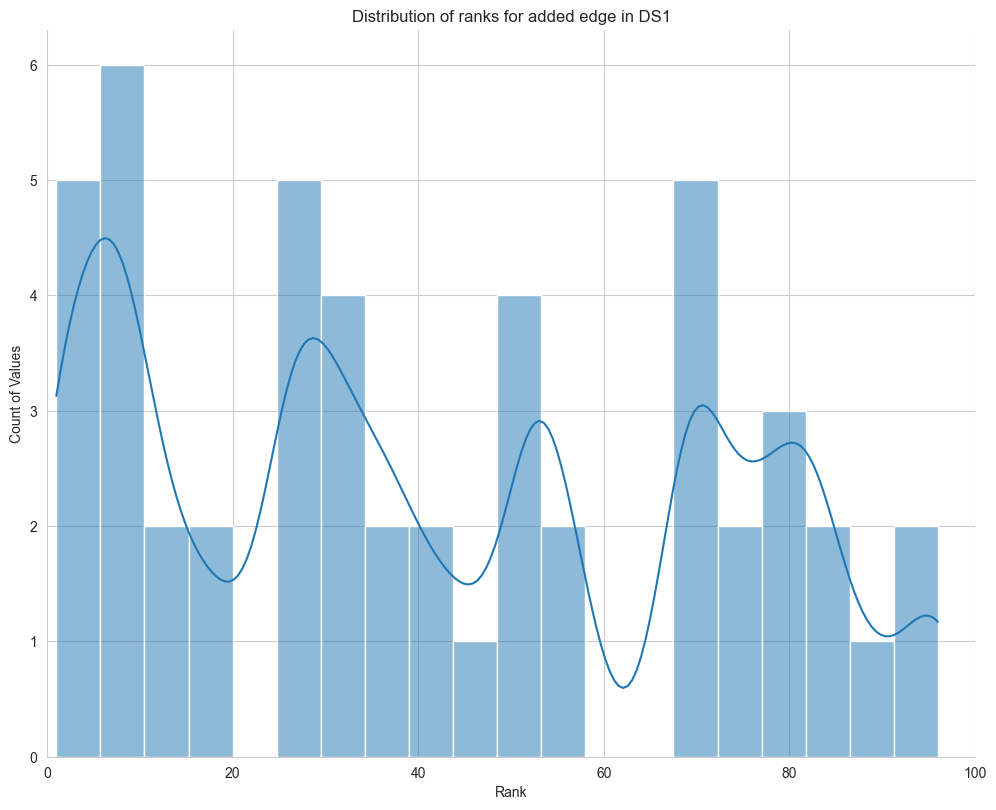

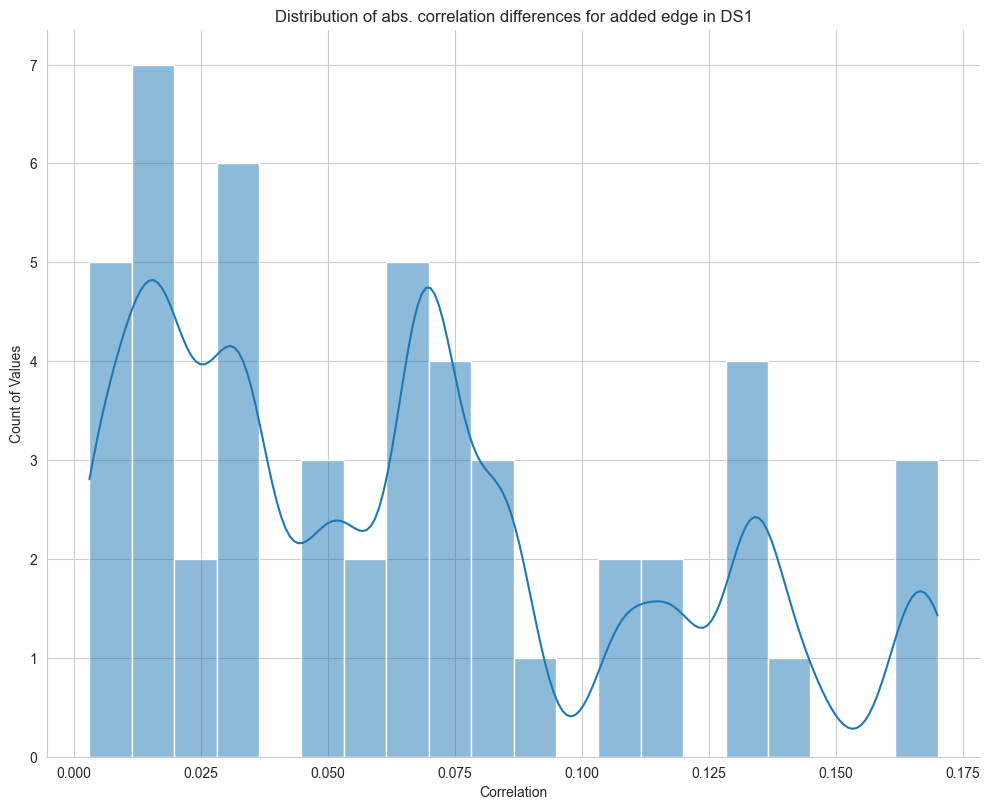

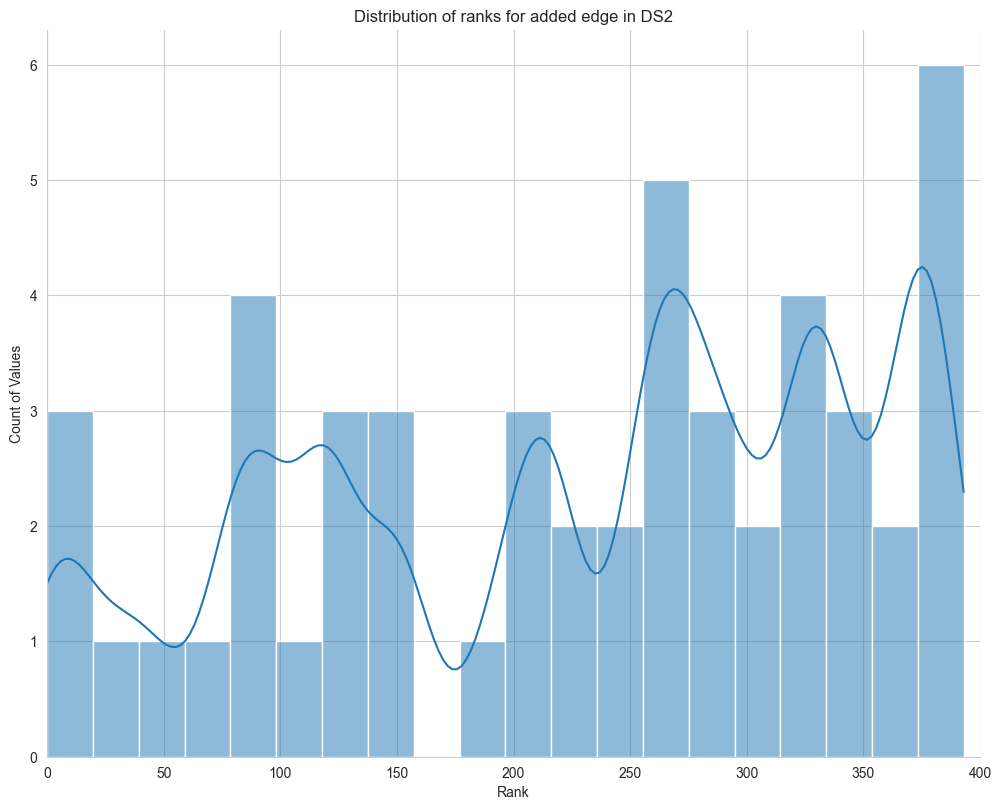

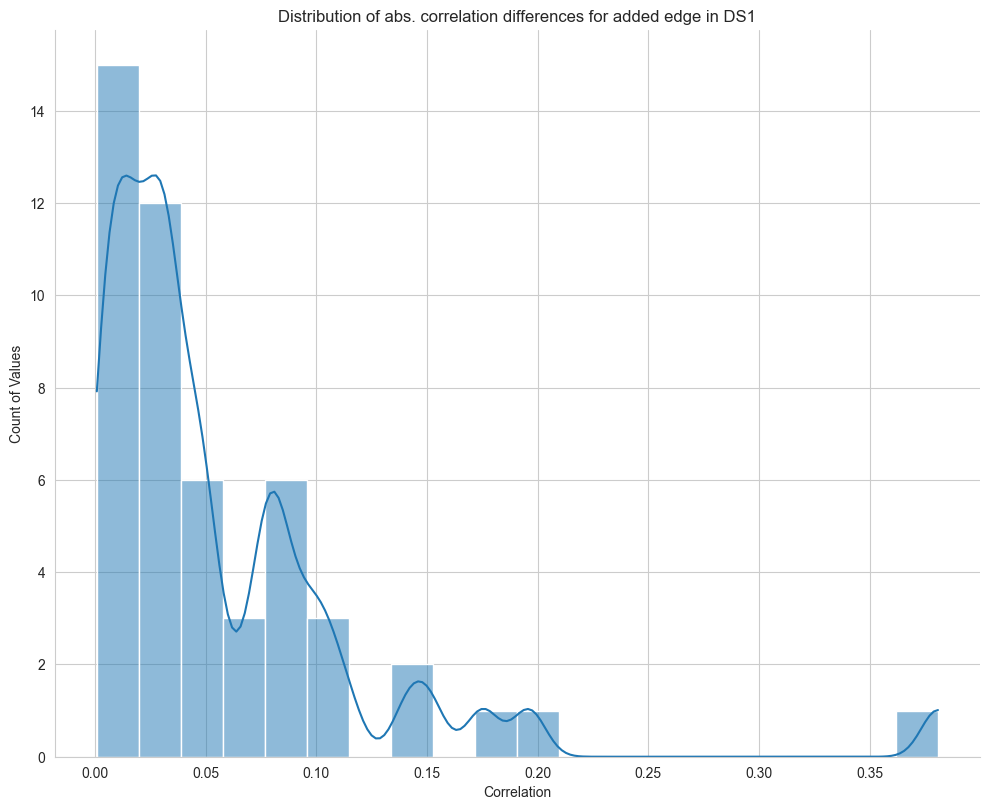

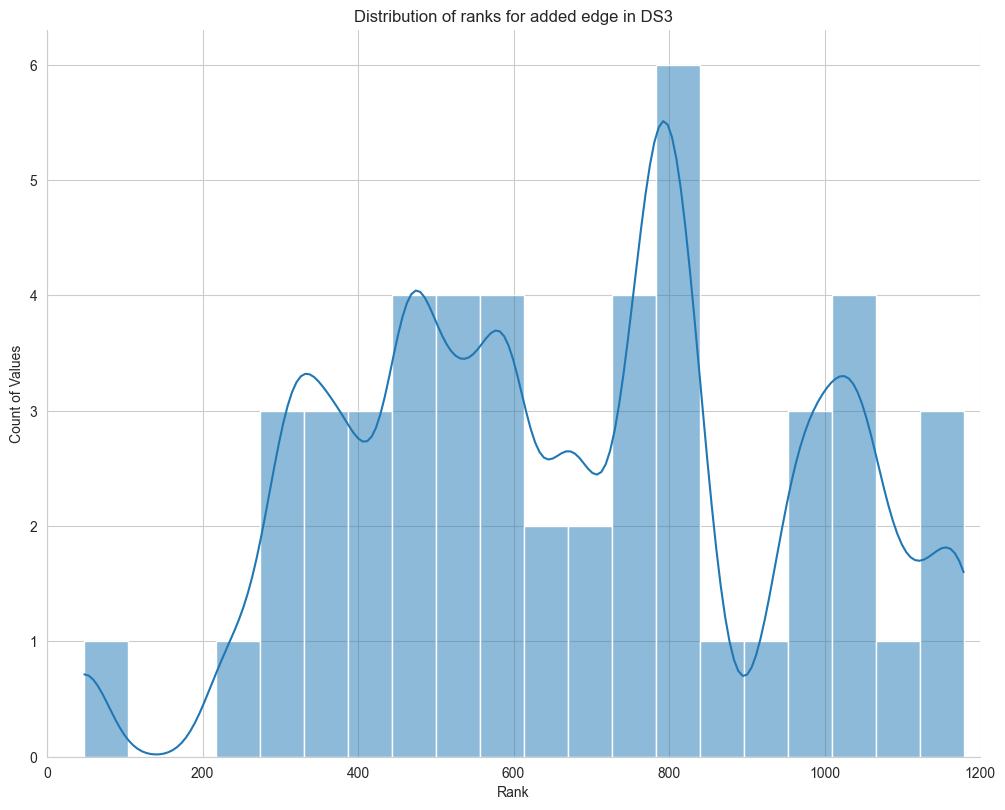

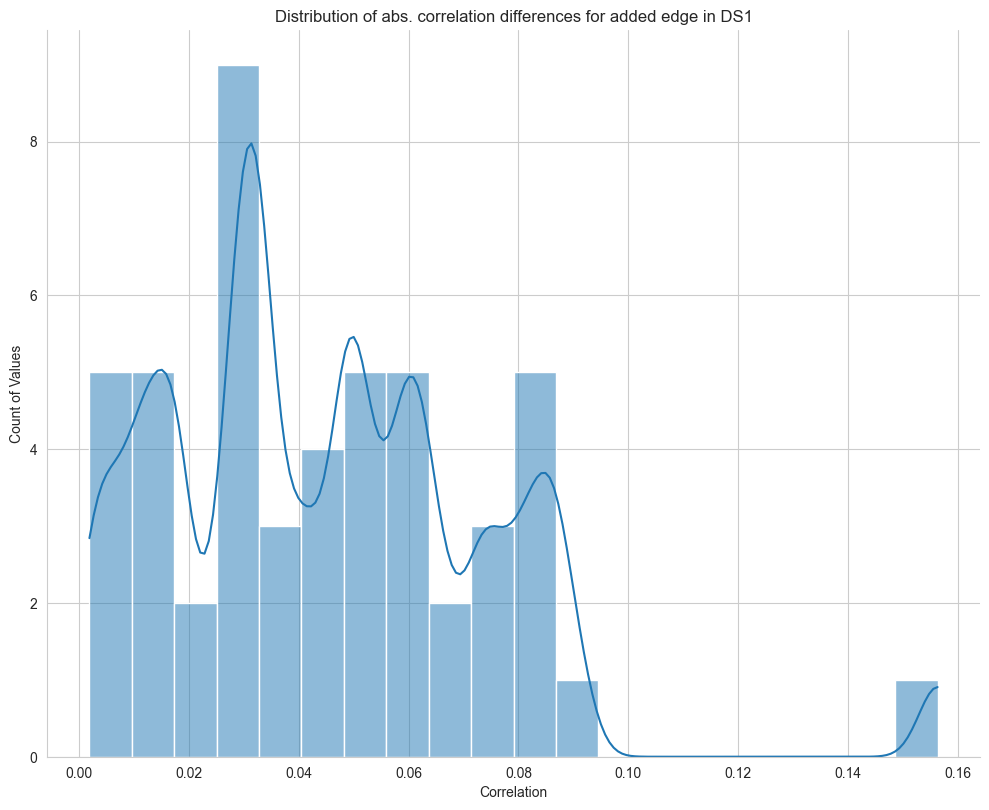

In [20]:
import seaborn as sns
## Plot the results from the experiment
dataset_id = 1
experiment_dir = os.path.join(os.getcwd(), 'experiments/edge_finding/')
for id in range(1, 4):
    experiment_file = os.path.join(experiment_dir, f"DS{id}_edge_finding_experiment_fixed_edge.csv")

    load_dir = os.path.join(imp_dir, f'DS{id}')
    save_name = 'DS6_expr.npy'

    expr = np.load(os.path.join(load_dir, save_name))
    lim = expr.shape[1]
    

    df = pd.read_csv(experiment_file)
    sns.set_style("whitegrid")
    # density plot
    plot = sns.displot(df['Rank'], kde=True, bins=20, kde_kws={'bw_adjust': 0.25}, height=8, aspect=1.25)
    plot.set(xlim=(0, lim))
    plot.set_axis_labels('Rank', 'Count of Values')
    plt.title(f'Distribution of ranks for added edge in DS{id}')


    plot = sns.displot(df['Correlation'], kde=True, bins=20, kde_kws={'bw_adjust': 0.25}, height=8, aspect=1.25)
    #plot.set(xlim=(0, 1))
    plot.set_axis_labels('Correlation', 'Count of Values')
    plt.title(f'Distribution of abs. correlation differences for added edge in DS{dataset_id}')
